
# Product level Impact of 3.2 Beer in Kansas

In [1]:
# packages used
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import metrics
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
import matplotlib as mpl
import matplotlib.pyplot as plt
import re
import statsmodels.formula.api as smf
import scipy.stats as stats
import pylab as pl
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

### Load Store Data that contains channel info

In [2]:
#load the All stores in Kansas
All_Stores_Kansas = pd.read_csv('AllStoresKansas.csv')
All_Stores_Kansas = All_Stores_Kansas.rename(columns = {'WJXBFS1':'PROD_DEPLETION'})
All_Stores_Kansas.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,101735574,CORONA EX 12PK CAN,LIQUOR,CONVENTIONAL LIQUOR,OFF,4.00
1,101713286,MODELO NEGRA 12PK BT,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,ON,2.00
2,102756894,CORONA EX 3.2 12PK BT,EXTENDED MASTER ON-PREMISE,RESTAURANT NA,ON,132.00
3,100963764,MODELO ESP 3.2 12PK BT,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,OFF,2.00
4,101403842,CORONA EX 18PK CAN,LIQUOR,CONVENTIONAL LIQUOR,OFF,23.25


In [3]:
#clean data

#remove NA Depletion 
All_Stores_Kansas = All_Stores_Kansas.loc[All_Stores_Kansas['PROD_DEPLETION'].notnull(),:]

#remove Negative Depletion
All_Stores_Kansas = All_Stores_Kansas.loc[All_Stores_Kansas['PROD_DEPLETION'] > 0.0,:] 
All_Stores_Kansas.shape

(24055, 6)

In [4]:
print('There are', len(All_Stores_Kansas['RTL_STORE_CD'].unique()), 'unique stores in Kansas Data')

There are 2976 unique stores in Kansas Data


In [5]:
All_Stores_Kansas['RTL_CHANNEL_DSC'].unique()

array(['LIQUOR', 'BAR/NIGHTCLUB', 'EXTENDED MASTER ON-PREMISE',
       'CONVENIENCE STORE', 'EXTENDED MASTER OFF-PREMISE', 'DRUG',
       'GROCERY', 'DINING', 'RECREATION', 'LODGING',
       'MILITARY OFF-PREMISE', 'NON RETAIL', 'MILITARY ON-PREMISE',
       'CATERER', 'MASS MERCHANDISER', 'WHOLESALE CLUB',
       'DISTRIBUTOR/SUB-DISTRIBUTOR', 'CIGARETTE OUTLET', 'UNKNOWN'], dtype=object)

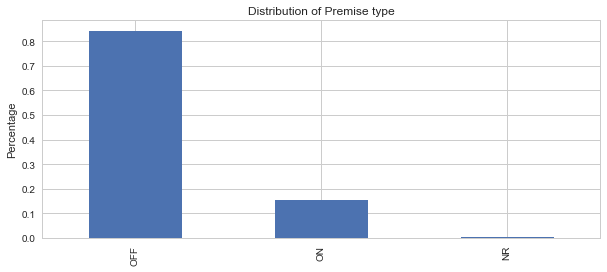

In [6]:
# Kansas Stores by Premise type
premise_type = All_Stores_Kansas.loc[:,'RTL_PREMISE_TYPE_CD']
premise_type = premise_type.value_counts()/len(premise_type)
ax = premise_type.plot.bar(figsize=(10,4), title = 'Distribution of Premise type')
ax.set_ylabel("Percentage");

### Load Product Data for On-Premise

In [7]:
LowPoint = pd.read_csv('KansasLowPointProducts.csv')
LowPointOn = LowPoint.loc[LowPoint['RTL_PREMISE_TYPE_CD'] == 'ON', :].reset_index(drop = True)
Top5LowPointOn = LowPointOn.head(10)['ITEM_MASTER_SKU_DSC']
Top5LowPointOn

0       CORONA EX 3.2 6PK BT
1      CORONA EX 3.2 12PK BT
2          CORONA LT 18PK BT
3      MODELO ESP 3.2 6PK BT
4     MODELO ESP 3.2 12PK BT
5    CORONA LIGHT 1/2 BL KEG
6    MODELO ESP 3.2 12PK CAN
7    MODELO ESP 3.2 24OZ CAN
8          CORONA LT 24PK BT
9      CORONA EX 3.2 24OZ BT
Name: ITEM_MASTER_SKU_DSC, dtype: object

In [8]:
#select top 5 products that are comparable:
Top5LowPointOn = Top5LowPointOn[[0,1,3,4,6]]
#put the products and their pairs into datafame
Top5_LowPoint_On_Pairs_DF = pd.DataFrame(Top5LowPointOn).reset_index(drop=True)
Top5_LowPoint_On_Pairs_DF['PAIRS'] = ['CORONA EX 6PK BT', 'CORONA EX 12PK BT', 'MODELO ESP 6PK BT', 'MODELO ESP 12PK BT', 'MODELO ESP 12PK CAN']
Top5_LowPoint_On_Pairs_DF

,ITEM_MASTER_SKU_DSC,PAIRS
0,CORONA EX 3.2 6PK BT,CORONA EX 6PK BT
1,CORONA EX 3.2 12PK BT,CORONA EX 12PK BT
2,MODELO ESP 3.2 6PK BT,MODELO ESP 6PK BT
3,MODELO ESP 3.2 12PK BT,MODELO ESP 12PK BT
4,MODELO ESP 3.2 12PK CAN,MODELO ESP 12PK CAN


In [9]:
BeerList_On = list(Top5_LowPoint_On_Pairs_DF['ITEM_MASTER_SKU_DSC']) + list(Top5_LowPoint_On_Pairs_DF['PAIRS'])
BeerList_On

['CORONA EX 3.2 6PK BT',
 'CORONA EX 3.2 12PK BT',
 'MODELO ESP 3.2 6PK BT',
 'MODELO ESP 3.2 12PK BT',
 'MODELO ESP 3.2 12PK CAN',
 'CORONA EX 6PK BT',
 'CORONA EX 12PK BT',
 'MODELO ESP 6PK BT',
 'MODELO ESP 12PK BT',
 'MODELO ESP 12PK CAN']

### Analysis for On-Premise

In [10]:
#Subset On-premise stores 
Top5_On_pairs_stores = All_Stores_Kansas.loc[All_Stores_Kansas['RTL_PREMISE_TYPE_CD'] == 'ON', :]

#Subset On-premise stoers that sell top 5 pairs of beer (10 products)
Top5_On_pairs_stores= Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(BeerList_On)].reset_index(drop=True)

Top5_On_pairs_stores.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,102756894,CORONA EX 3.2 12PK BT,EXTENDED MASTER ON-PREMISE,RESTAURANT NA,ON,132.0
1,103766853,MODELO ESP 12PK BT,DINING,CASUAL DINING,ON,2.0
2,101980303,CORONA EX 3.2 6PK BT,DINING,FAST CASUAL,ON,2.0
3,101979140,MODELO ESP 12PK BT,BAR/NIGHTCLUB,IRISH PUB,ON,46.0
4,101923300,CORONA EX 3.2 12PK BT,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,ON,1.0


In [11]:
print('There are', len(Top5_On_pairs_stores['RTL_STORE_CD'].unique()), 'stores that sell the top 5 pair products')

There are 707 stores that sell the top 5 pair products


In [12]:
Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].unique()

array(['CORONA EX 3.2 12PK BT', 'MODELO ESP 12PK BT',
       'CORONA EX 3.2 6PK BT', 'MODELO ESP 6PK BT', 'CORONA EX 12PK BT',
       'MODELO ESP 12PK CAN', 'CORONA EX 6PK BT', 'MODELO ESP 3.2 6PK BT',
       'MODELO ESP 3.2 12PK BT', 'MODELO ESP 3.2 12PK CAN'], dtype=object)

In [13]:
#create a graph_DF for explanatory analysis.
graph_DF = Top5_On_pairs_stores
graph_DF['Product'] = graph_DF['ITEM_MASTER_SKU_DSC']
for index in range(len(graph_DF['Product'])):
    if '3.2 ' in graph_DF.loc[index, 'Product']:
        graph_DF.loc[index, 'Product'] = graph_DF.loc[index, 'Product'].replace('3.2 ','')
graph_DF['is32'] = graph_DF['ITEM_MASTER_SKU_DSC'] != graph_DF['Product']        

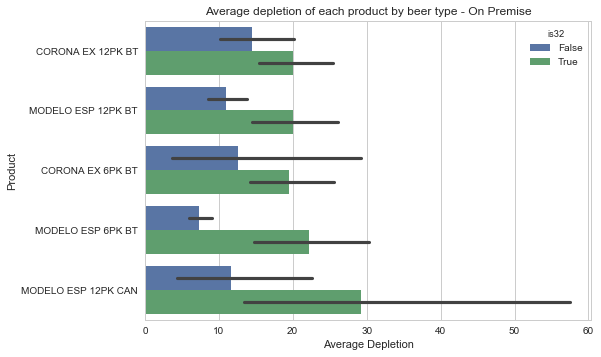

In [14]:
#plot Average depletion of each product for On-premise
plt.title("Average depletion of each product by beer type - On Premise")
graph = sns.barplot(x='PROD_DEPLETION', y="Product", hue="is32", data=graph_DF)
graph.set(xlabel='Average Depletion', ylabel='Product');

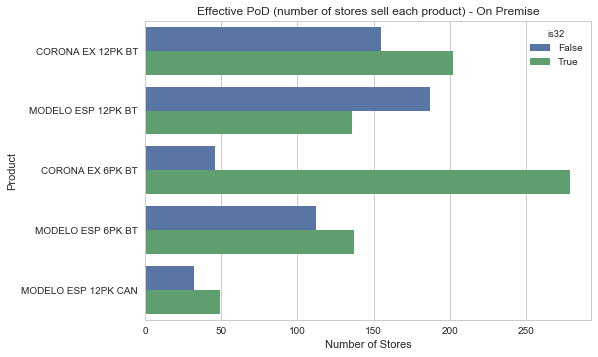

In [15]:
#plot number of stores sell each product for On-premise
plt.title("Effective PoD (number of stores sell each product) - On Premise")
graph = sns.countplot(y='Product', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['Product'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Product');

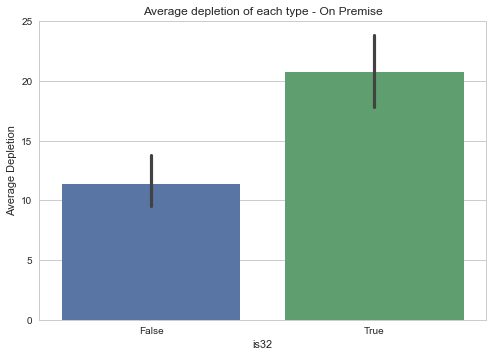

In [16]:
# Average depletion for 3.2 and Non 3.2 products
plt.title("Average depletion of each type - On Premise")
graph = sns.barplot(x='is32', y = 'PROD_DEPLETION', data=graph_DF)
graph.set(ylabel='Average Depletion');

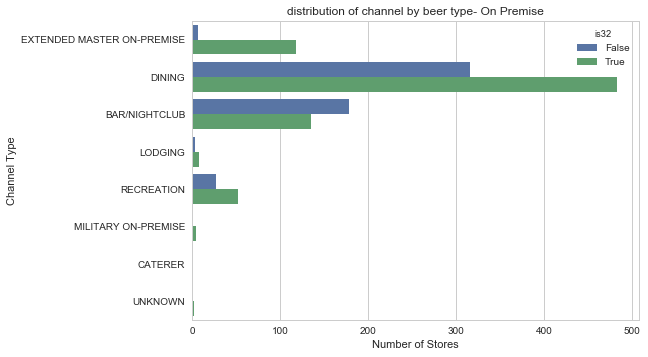

In [17]:
#plot distribution of channel by beer type for On-premise
plt.title("distribution of channel by beer type- On Premise")
graph = sns.countplot(y='RTL_CHANNEL_DSC', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['RTL_CHANNEL_DSC'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Channel Type');

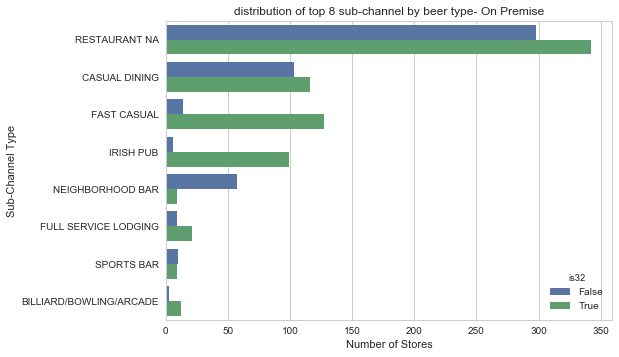

In [18]:
#plot distribution of Sub-channel by beer type for On-premise
plt.title("distribution of top 8 sub-channel by beer type- On Premise")
graph = sns.countplot(y='RTL_SUBCHANNEL_DSC', hue="is32", data=graph_DF, order=graph_DF.RTL_SUBCHANNEL_DSC.value_counts().iloc[:8].index)
graph.set_yticklabels(graph_DF['RTL_SUBCHANNEL_DSC'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Sub-Channel Type');

In [19]:
graph_DF.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION,Product,is32
0,102756894,CORONA EX 3.2 12PK BT,EXTENDED MASTER ON-PREMISE,RESTAURANT NA,ON,132.0,CORONA EX 12PK BT,True
1,103766853,MODELO ESP 12PK BT,DINING,CASUAL DINING,ON,2.0,MODELO ESP 12PK BT,False
2,101980303,CORONA EX 3.2 6PK BT,DINING,FAST CASUAL,ON,2.0,CORONA EX 6PK BT,True
3,101979140,MODELO ESP 12PK BT,BAR/NIGHTCLUB,IRISH PUB,ON,46.0,MODELO ESP 12PK BT,False
4,101923300,CORONA EX 3.2 12PK BT,BAR/NIGHTCLUB,NEIGHBORHOOD BAR,ON,1.0,CORONA EX 12PK BT,True


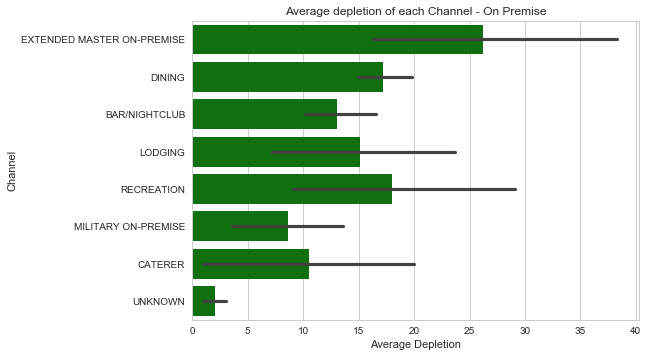

In [20]:
# Average depletion for each channel
plt.title("Average depletion of each Channel - On Premise")
graph = sns.barplot(y='RTL_CHANNEL_DSC', x = 'PROD_DEPLETION', data=graph_DF, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel')
graph.set_yticklabels(graph_DF['RTL_CHANNEL_DSC'].unique());

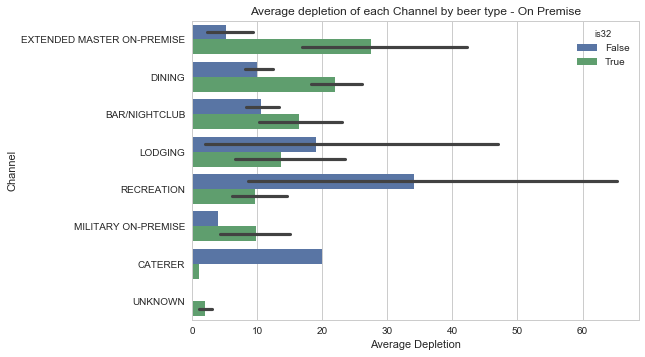

In [21]:
# Average depletion for each channel by beer type
plt.title("Average depletion of each Channel by beer type - On Premise")
graph = sns.barplot(y='RTL_CHANNEL_DSC', x = 'PROD_DEPLETION', hue = 'is32', data=graph_DF)
graph.set(xlabel='Average Depletion', ylabel='Channel')
graph.set_yticklabels(graph_DF['RTL_CHANNEL_DSC'].unique());

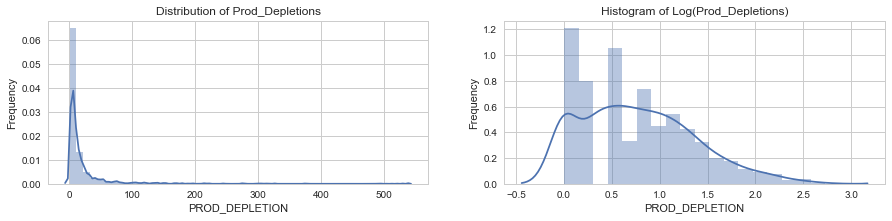

In [22]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title('Distribution of Prod_Depletions')
sns.distplot(Top5_On_pairs_stores['PROD_DEPLETION'])
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.title('Histogram of Log(Prod_Depletions)')
sns.distplot(np.log10(Top5_On_pairs_stores['PROD_DEPLETION'].values))
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency');

## Regression Analysis on Five products for On-premise

### Pair 1

In [23]:
#pair1:
subset1 = Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[0, :]))].reset_index(drop=True)
subset1.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION,Product,is32
0,101980303,CORONA EX 3.2 6PK BT,DINING,FAST CASUAL,ON,2.0,CORONA EX 6PK BT,True
1,101737336,CORONA EX 6PK BT,DINING,CASUAL DINING,ON,1.0,CORONA EX 6PK BT,False
2,102269014,CORONA EX 3.2 6PK BT,EXTENDED MASTER ON-PREMISE,SPECIAL EVENTS,ON,8.0,CORONA EX 6PK BT,True
3,101942314,CORONA EX 3.2 6PK BT,DINING,CASUAL DINING,ON,190.0,CORONA EX 6PK BT,True
4,103701509,CORONA EX 3.2 6PK BT,DINING,CASUAL DINING,ON,39.0,CORONA EX 6PK BT,True


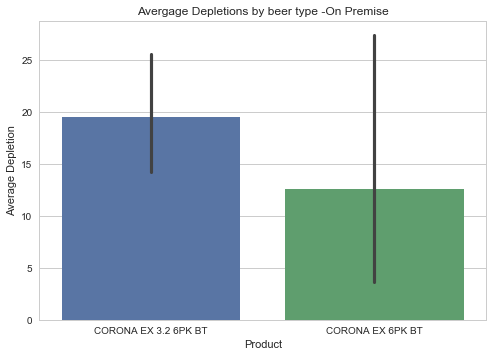

In [24]:
#plot average depletion per beer type for On-premise
plt.title("Avergage Depletions by beer type -On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset1)
graph.set(xlabel='Product', ylabel='Average Depletion');

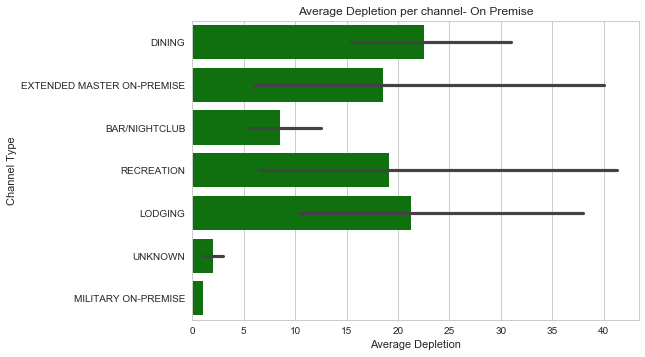

In [25]:
#plot average depletion per channel for On-premise
plt.title("Average Depletion per channel- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset1, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

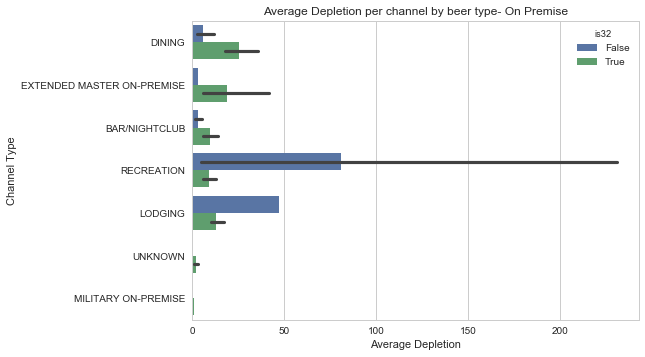

In [26]:
#plot Average Depletion per channel by beer type for On-premise
plt.title("Average Depletion per channel by beer type- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset1)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [27]:
#pair1: 
Regression_ON_pair1 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(RTL_CHANNEL_DSC)', data= subset1)
print(Regression_ON_pair1.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.105
Model:                                OLS   Adj. R-squared:                  0.085
Method:                     Least Squares   F-statistic:                     5.290
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           9.84e-06
Time:                            15:51:36   Log-Likelihood:                -529.91
No. Observations:                     325   AIC:                             1076.
Df Residuals:                         317   BIC:                             1106.
Df Model:                               7                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

### Pair 2:  

In [28]:
#pair 2:
subset2 = Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[1, :]))].reset_index(drop=True)

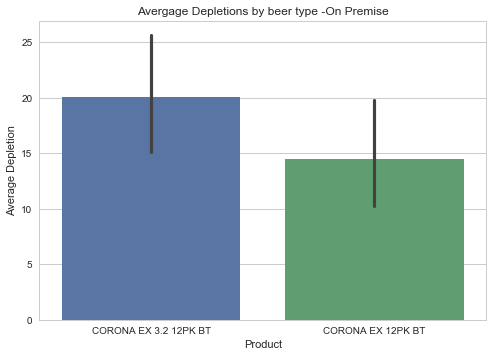

In [29]:
#plot average depletion per beer type for On-premise
plt.title("Avergage Depletions by beer type -On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset2)
graph.set(xlabel='Product', ylabel='Average Depletion');

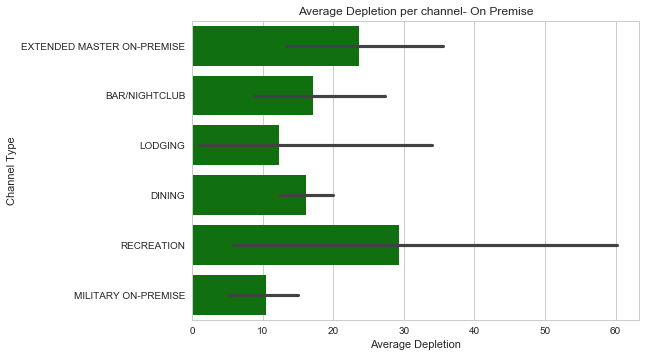

In [30]:
#plot average depletion per channel for On-premise
plt.title("Average Depletion per channel- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset2, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

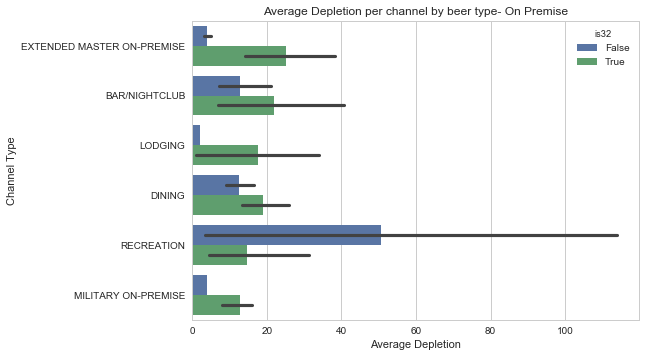

In [31]:
#plot Average Depletion per channel by beer type for On-premise
plt.title("Average Depletion per channel by beer type- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset2)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [32]:
#pair 2: 
Regression_ON_pair2 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(RTL_CHANNEL_DSC)', data= subset2)
print(Regression_ON_pair2.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.009
Model:                                OLS   Adj. R-squared:                 -0.008
Method:                     Least Squares   F-statistic:                    0.5165
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):              0.796
Time:                            15:51:37   Log-Likelihood:                -617.01
No. Observations:                     357   AIC:                             1248.
Df Residuals:                         350   BIC:                             1275.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

### Pair 3: 

In [33]:
#pair 3:
subset3 = Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[2, :]))].reset_index(drop=True)

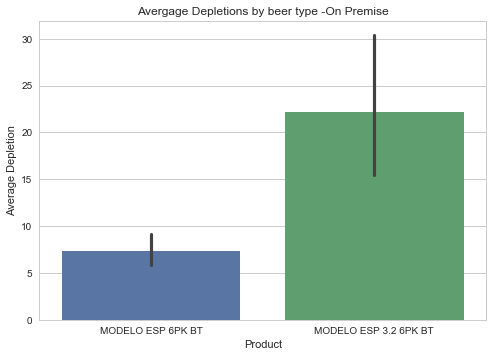

In [34]:
#plot average depletion per beer type for On-premise
plt.title("Avergage Depletions by beer type -On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset3)
graph.set(xlabel='Product', ylabel='Average Depletion');

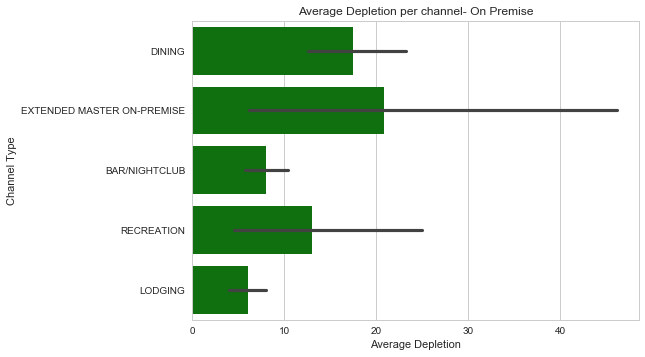

In [35]:
#plot average depletion per channel for On-premise
plt.title("Average Depletion per channel- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset3, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

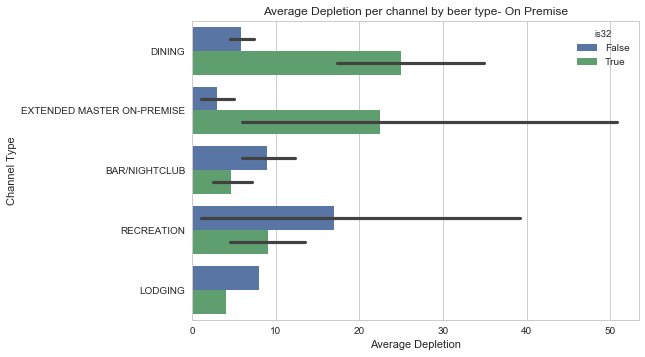

In [36]:
#plot Average Depletion per channel by beer type for On-premise
plt.title("Average Depletion per channel by beer type- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset3)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [37]:
#pair 3: 
Regression_ON_pair3 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(RTL_CHANNEL_DSC)', data= subset3)
print(Regression_ON_pair3.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.059
Model:                                OLS   Adj. R-squared:                  0.039
Method:                     Least Squares   F-statistic:                     3.023
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):             0.0115
Time:                            15:51:39   Log-Likelihood:                -403.21
No. Observations:                     249   AIC:                             818.4
Df Residuals:                         243   BIC:                             839.5
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

### pair 4  

In [38]:
#pair 4 
subset4 = Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[3, :]))].reset_index(drop=True)

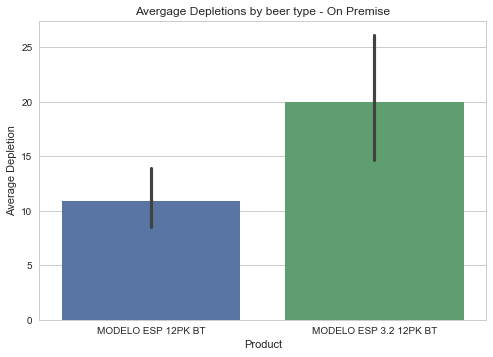

In [39]:
#plot average depletion per beer type for On-premise
plt.title("Avergage Depletions by beer type - On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset4)
graph.set(xlabel='Product', ylabel='Average Depletion');

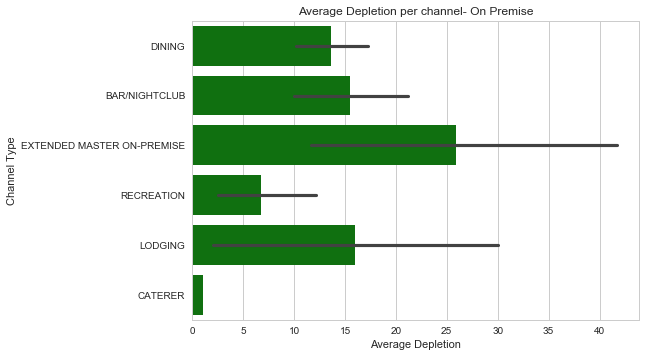

In [40]:
#plot average depletion per channel for On-premise
plt.title("Average Depletion per channel- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset4, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

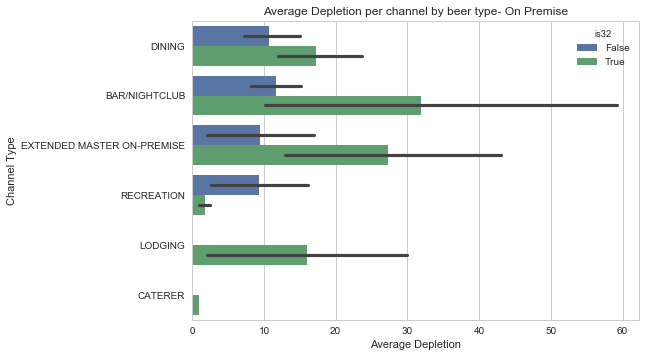

In [41]:
#plot Average Depletion per channel by beer type for On-premise
plt.title("Average Depletion per channel by beer type- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset4)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [42]:
#pair 4  
Regression_ON_pair4 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(RTL_CHANNEL_DSC)', data= subset4)
print(Regression_ON_pair4.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.024
Model:                                OLS   Adj. R-squared:                  0.005
Method:                     Least Squares   F-statistic:                     1.282
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):              0.265
Time:                            15:51:40   Log-Likelihood:                -559.62
No. Observations:                     323   AIC:                             1133.
Df Residuals:                         316   BIC:                             1160.
Df Model:                               6                                         
Covariance Type:                nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------

### pair 5 

In [43]:
#pair 5 
subset5 = Top5_On_pairs_stores.loc[Top5_On_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_On_Pairs_DF.loc[4, :]))].reset_index(drop=True)

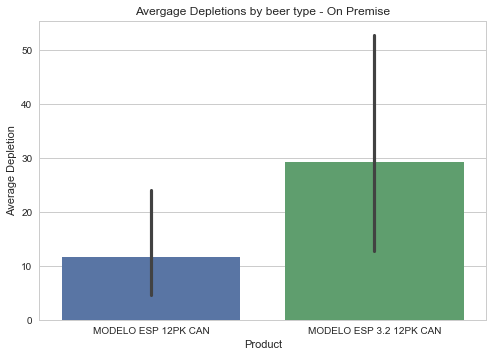

In [44]:
#plot average depletion per beer type for On-premise
plt.title("Avergage Depletions by beer type - On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset5)
graph.set(xlabel='Product', ylabel='Average Depletion');

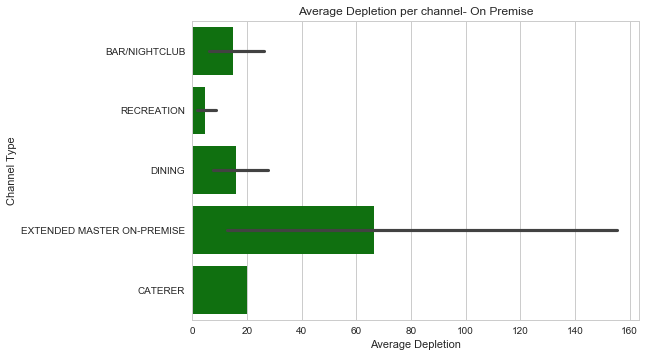

In [45]:
#plot average depletion per channel for On-premise
plt.title("Average Depletion per channel- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset5, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

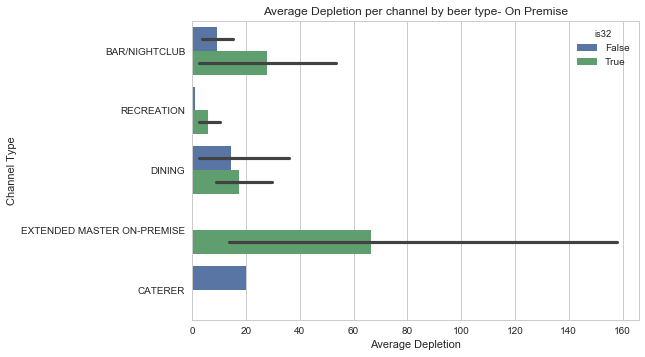

In [46]:
#plot Average Depletion per channel by beer type for On-premise
plt.title("Average Depletion per channel by beer type- On Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset5)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [47]:
#pair 5
Regression_ON_pair5 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(RTL_CHANNEL_DSC)', data= subset5)
print(Regression_ON_pair5.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.109
Model:                                OLS   Adj. R-squared:                  0.050
Method:                     Least Squares   F-statistic:                     1.835
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):              0.116
Time:                            15:51:41   Log-Likelihood:                -145.41
No. Observations:                      81   AIC:                             302.8
Df Residuals:                          75   BIC:                             317.2
Df Model:                               5                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

### Load Product Data for Off-Premise

In [48]:
#load the product data for Off Premise 
LowPointOff = LowPoint.loc[LowPoint['RTL_PREMISE_TYPE_CD'] == 'OFF', :].reset_index(drop = True)
Top5LowPointOff = LowPointOff.head(10)['ITEM_MASTER_SKU_DSC']
Top5LowPointOff

0      CORONA EX 3.2 12PK BT
1          CORONA LT 12PK BT
2    MODELO ESP 3.2 12PK CAN
3       CORONA EX 3.2 6PK BT
4    MODELO CHELADA 24OZ CAN
5      CORONA EX 3.2 18PK BT
6           CORONA LT 6PK BT
7     MODELO ESP 3.2 12PK BT
8    MODELO ESP 3.2 18PK CAN
9      MODELO ESP 3.2 6PK BT
Name: ITEM_MASTER_SKU_DSC, dtype: object

In [49]:
#select top 5 products that are comparable:
Top5LowPointOff = Top5LowPointOff[[0,2,3,5,7]]
#put the products and their pairs into datafame
Top5_LowPoint_Off_Pairs_DF = pd.DataFrame(Top5LowPointOff).reset_index(drop=True)
Top5_LowPoint_Off_Pairs_DF['PAIRS'] = ['CORONA EX 12PK BT', 'MODELO ESP 12PK CAN','CORONA EX 6PK BT', 'CORONA EX 18PK BT', 'MODELO ESP 12PK BT']
Top5_LowPoint_Off_Pairs_DF

,ITEM_MASTER_SKU_DSC,PAIRS
0,CORONA EX 3.2 12PK BT,CORONA EX 12PK BT
1,MODELO ESP 3.2 12PK CAN,MODELO ESP 12PK CAN
2,CORONA EX 3.2 6PK BT,CORONA EX 6PK BT
3,CORONA EX 3.2 18PK BT,CORONA EX 18PK BT
4,MODELO ESP 3.2 12PK BT,MODELO ESP 12PK BT


In [50]:
BeerList_Off = list(Top5_LowPoint_Off_Pairs_DF['ITEM_MASTER_SKU_DSC']) + list(Top5_LowPoint_Off_Pairs_DF['PAIRS'])
BeerList_Off

['CORONA EX 3.2 12PK BT',
 'MODELO ESP 3.2 12PK CAN',
 'CORONA EX 3.2 6PK BT',
 'CORONA EX 3.2 18PK BT',
 'MODELO ESP 3.2 12PK BT',
 'CORONA EX 12PK BT',
 'MODELO ESP 12PK CAN',
 'CORONA EX 6PK BT',
 'CORONA EX 18PK BT',
 'MODELO ESP 12PK BT']

### Analysis for Off-Premise

In [51]:
#Subset Off-premise stores 
Top5_Off_pairs_stores = All_Stores_Kansas.loc[All_Stores_Kansas['RTL_PREMISE_TYPE_CD'] == 'OFF', :]

#Subset Off-premise stoers that sell top 5 pairs of beer (10 products)
Top5_Off_pairs_stores= Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(BeerList_Off)].reset_index(drop=True)

Top5_Off_pairs_stores.head()

,RTL_STORE_CD,ITEM_MASTER_SKU_DSC,RTL_CHANNEL_DSC,RTL_SUBCHANNEL_DSC,RTL_PREMISE_TYPE_CD,PROD_DEPLETION
0,100963764,MODELO ESP 3.2 12PK BT,CONVENIENCE STORE,CONVENTIONAL CONVENIENCE,OFF,2.0
1,102159390,MODELO ESP 12PK BT,LIQUOR,CONVENTIONAL LIQUOR,OFF,49.0
2,101404100,CORONA EX 12PK BT,LIQUOR,CONVENTIONAL LIQUOR,OFF,53.0
3,107218024,MODELO ESP 3.2 12PK CAN,DRUG,CONVENTIONAL DRUG,OFF,2.0
4,100091971,MODELO ESP 3.2 12PK CAN,GROCERY,SUPERMARKET-CONVENTIONAL,OFF,22.0


In [1]:
len(Top5_Off_pairs_stores['RTL_STORE_CD'].unique())

NameError: name 'Top5_Off_pairs_stores' is not defined

In [53]:
Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].unique()

array(['MODELO ESP 3.2 12PK BT', 'MODELO ESP 12PK BT', 'CORONA EX 12PK BT',
       'MODELO ESP 3.2 12PK CAN', 'CORONA EX 3.2 6PK BT',
       'CORONA EX 3.2 12PK BT', 'CORONA EX 18PK BT', 'CORONA EX 6PK BT',
       'MODELO ESP 12PK CAN', 'CORONA EX 3.2 18PK BT'], dtype=object)

In [54]:
#create a graph_DF for explanatory analysis.
graph_DF = Top5_Off_pairs_stores
graph_DF['Product'] = graph_DF['ITEM_MASTER_SKU_DSC']
for index in range(len(graph_DF['Product'])):
    if '3.2 ' in graph_DF.loc[index, 'Product']:
        graph_DF.loc[index, 'Product'] = graph_DF.loc[index, 'Product'].replace('3.2 ','')
graph_DF['is32'] = graph_DF['ITEM_MASTER_SKU_DSC'] != graph_DF['Product']  

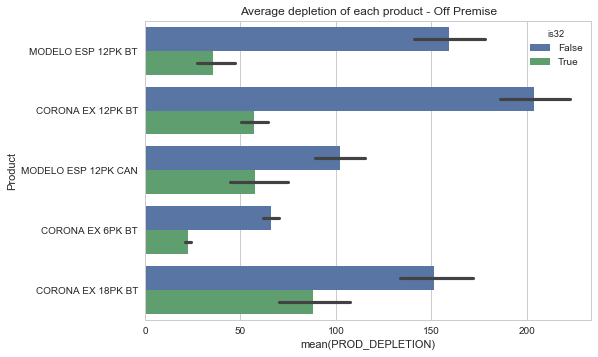

In [55]:
#plot Average depletion of each product for Off-premise
plt.title("Average depletion of each product - Off Premise")
sns.barplot(x='PROD_DEPLETION', y="Product", hue="is32", data=graph_DF);

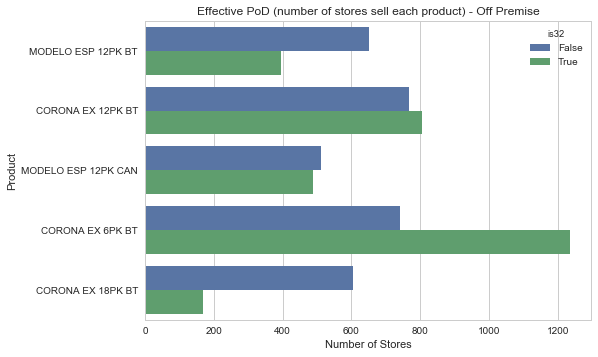

In [56]:
#plot number of stores sell each product for Off-premise
plt.title("Effective PoD (number of stores sell each product) - Off Premise")
graph = sns.countplot(y='Product', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['Product'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Product');

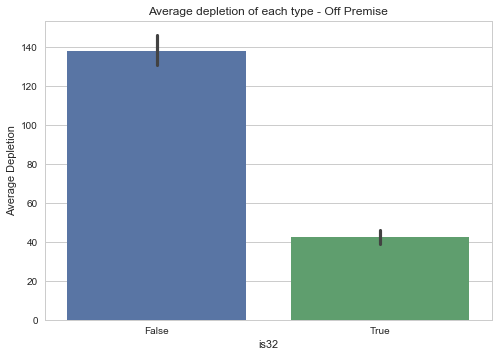

In [57]:
# Average depletion for 3.2 and Non 3.2 products
plt.title("Average depletion of each type - Off Premise")
graph = sns.barplot(x='is32', y = 'PROD_DEPLETION', data=graph_DF)
graph.set(ylabel='Average Depletion');

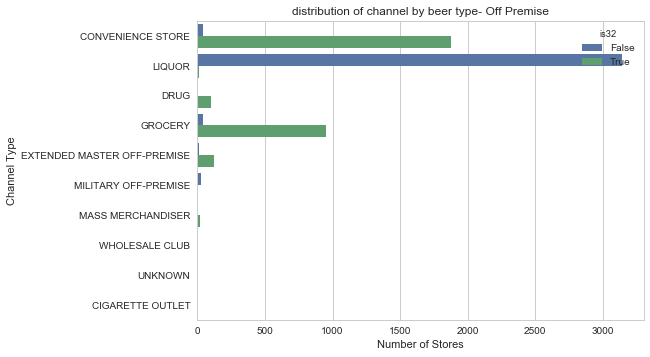

In [58]:
#plot distribution of channel by beer type for Off-premise
plt.title("distribution of channel by beer type- Off Premise")
graph = sns.countplot(y='RTL_CHANNEL_DSC', hue="is32", data=graph_DF)
graph.set_yticklabels(graph_DF['RTL_CHANNEL_DSC'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Channel Type');

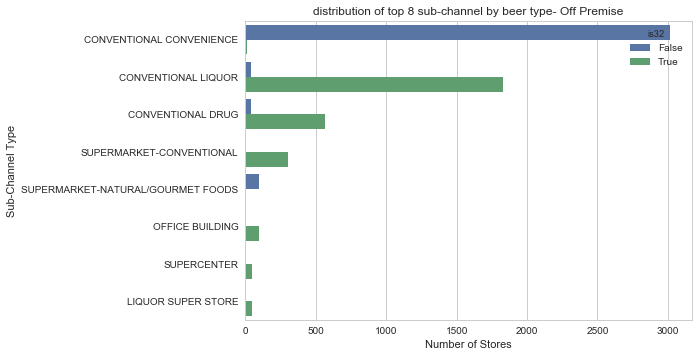

In [59]:
#plot distribution of Sub-channel by beer type for Off-premise
plt.title("distribution of top 8 sub-channel by beer type- Off Premise")
graph = sns.countplot(y='RTL_SUBCHANNEL_DSC', hue="is32", data=graph_DF, order=graph_DF.RTL_SUBCHANNEL_DSC.value_counts().iloc[:8].index)
graph.set_yticklabels(graph_DF['RTL_SUBCHANNEL_DSC'].unique(), rotation=0)
graph.set(xlabel='Number of Stores', ylabel='Sub-Channel Type');

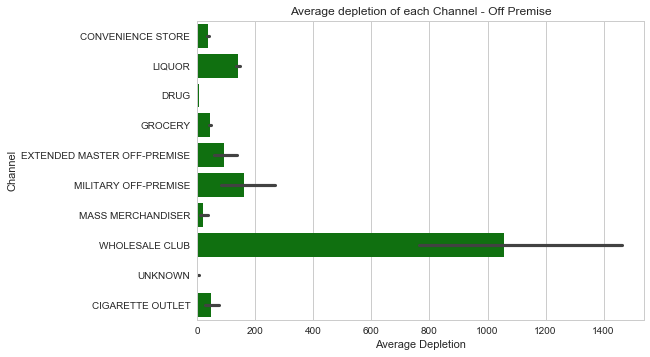

In [60]:
# Average depletion for each channel
plt.title("Average depletion of each Channel - Off Premise")
graph = sns.barplot(y='RTL_CHANNEL_DSC', x = 'PROD_DEPLETION', data=graph_DF, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel')
graph.set_yticklabels(graph_DF['RTL_CHANNEL_DSC'].unique());

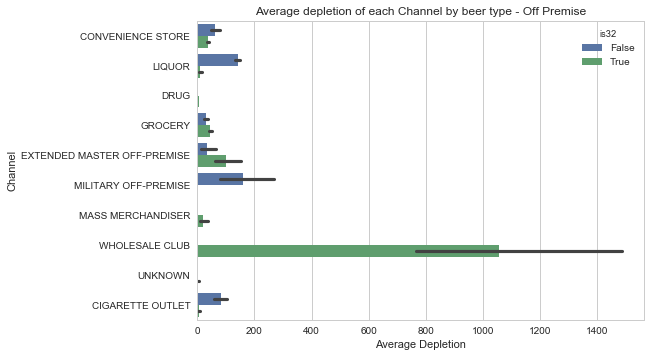

In [61]:
# Average depletion for each channel by beer type
plt.title("Average depletion of each Channel by beer type - Off Premise")
graph = sns.barplot(y='RTL_CHANNEL_DSC', x = 'PROD_DEPLETION', hue = 'is32', data=graph_DF)
graph.set(xlabel='Average Depletion', ylabel='Channel')
graph.set_yticklabels(graph_DF['RTL_CHANNEL_DSC'].unique());

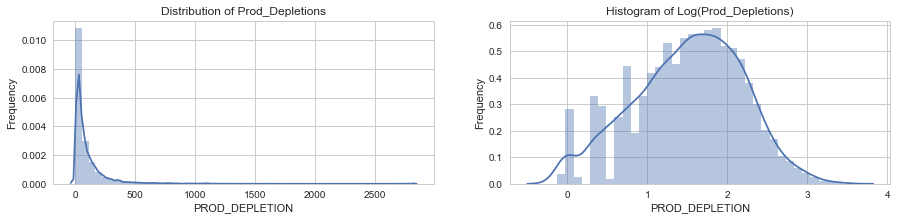

In [62]:
#Distribution of Depletions
f, axes = plt.subplots(1,2, figsize=(15, 3))
plt.subplot(1,2,1)
plt.title('Distribution of Prod_Depletions')
sns.distplot(Top5_Off_pairs_stores['PROD_DEPLETION'])
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency')

plt.subplot(1,2,2)
plt.title('Histogram of Log(Prod_Depletions)')
sns.distplot(np.log10(Top5_Off_pairs_stores['PROD_DEPLETION'].values))
plt.xlabel('PROD_DEPLETION')
plt.ylabel('Frequency');


## Regression Analysis on Five products for Off-premise

### Pair 1

In [63]:
subset1 = Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[0, :]))].reset_index(drop=True)

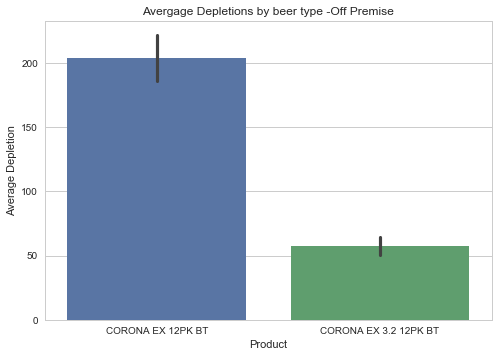

In [64]:
#plot average depletion per beer type for Off-premise
plt.title("Avergage Depletions by beer type -Off Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset1)
graph.set(xlabel='Product', ylabel='Average Depletion');

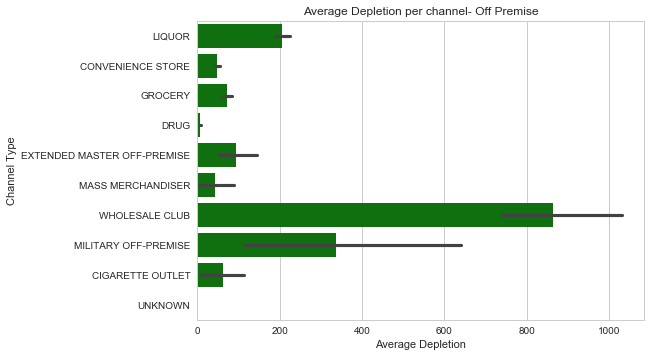

In [65]:
#plot average depletion per channel for Off-premise
plt.title("Average Depletion per channel- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset1, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

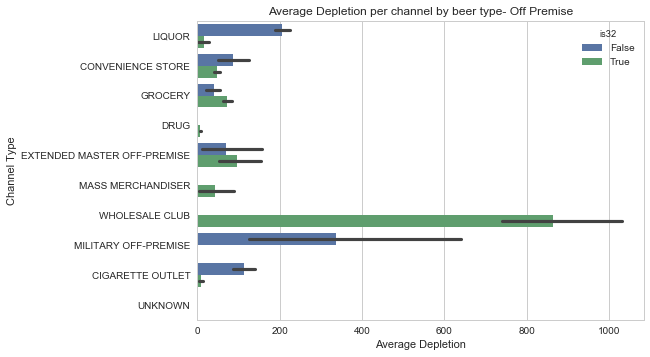

In [66]:
#plot Average Depletion per channel by beer type for Off-premise
plt.title("Average Depletion per channel by beer type- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset1)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [67]:
Regression_Off_pair1 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC) + C(RTL_CHANNEL_DSC)', data= subset1)
print(Regression_Off_pair1.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.333
Model:                                OLS   Adj. R-squared:                  0.328
Method:                     Least Squares   F-statistic:                     77.85
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):          1.34e-129
Time:                            15:51:50   Log-Likelihood:                -2625.6
No. Observations:                    1573   AIC:                             5273.
Df Residuals:                        1562   BIC:                             5332.
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

### pair2

In [68]:
subset2 = Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[1, :]))].reset_index(drop=True)

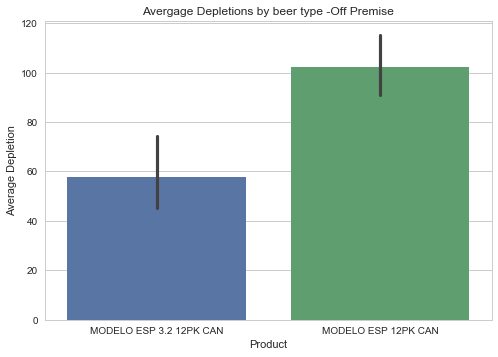

In [69]:
#plot average depletion per beer type for Off-premise
plt.title("Avergage Depletions by beer type -Off Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset2)
graph.set(xlabel='Product', ylabel='Average Depletion');

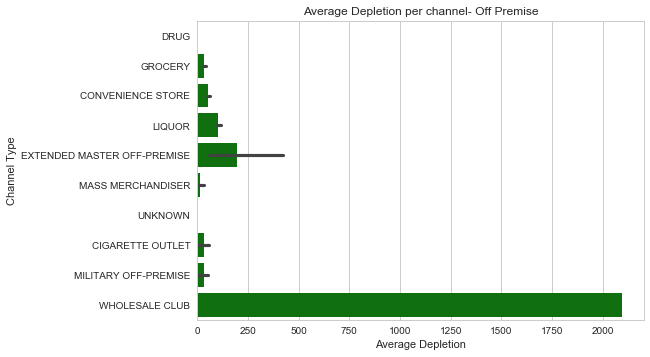

In [70]:
#plot average depletion per channel for Off-premise
plt.title("Average Depletion per channel- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset2, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

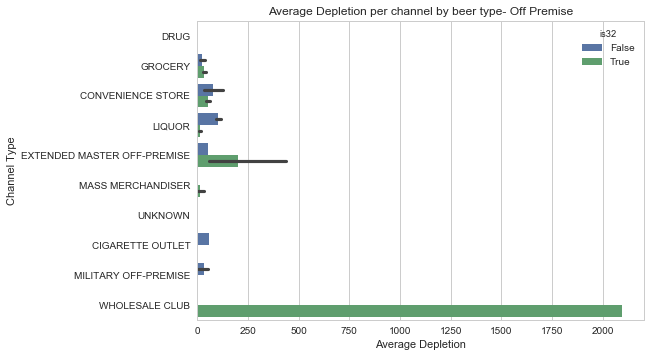

In [71]:
#plot Average Depletion per channel by beer type for Off-premise
plt.title("Average Depletion per channel by beer type- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset2)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [72]:
Regression_Off_pair2 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(RTL_CHANNEL_DSC)', data= subset2)
print(Regression_Off_pair2.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.087
Model:                                OLS   Adj. R-squared:                  0.078
Method:                     Least Squares   F-statistic:                     9.437
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           4.26e-15
Time:                            15:51:52   Log-Likelihood:                -1889.4
No. Observations:                    1001   AIC:                             3801.
Df Residuals:                         990   BIC:                             3855.
Df Model:                              10                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

### pair3

In [73]:
#pair3:
subset3 = Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[2, :]))].reset_index(drop=True)

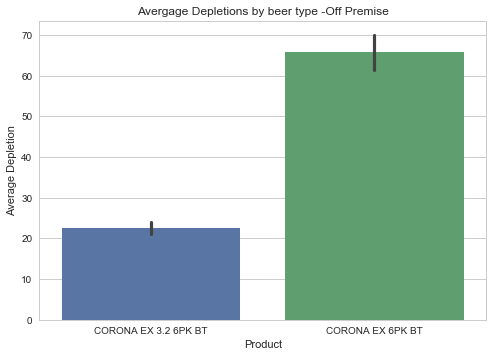

In [74]:
#plot average depletion per beer type for On-premise
plt.title("Avergage Depletions by beer type -Off Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset3)
graph.set(xlabel='Product', ylabel='Average Depletion');

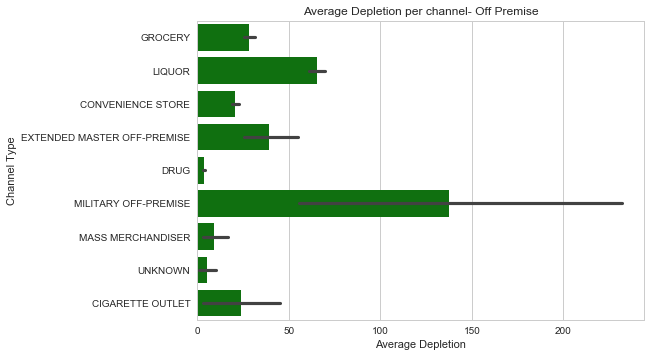

In [75]:
#plot average depletion per channel for On-premise
plt.title("Average Depletion per channel- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset3, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

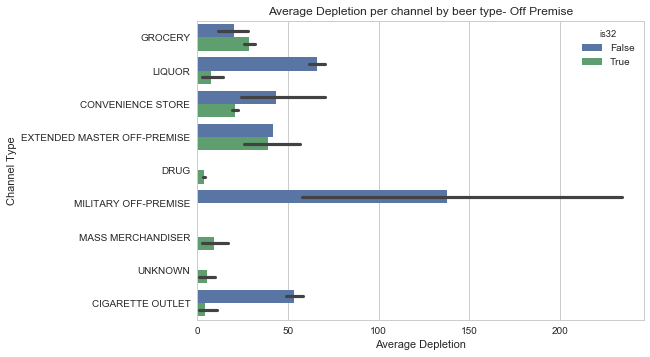

In [76]:
#plot Average Depletion per channel by beer type for On-premise
plt.title("Average Depletion per channel by beer type- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset3)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [77]:
Regression_Off_pair3 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)', data= subset3)
print(Regression_Off_pair3.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.185
Model:                                OLS   Adj. R-squared:                  0.184
Method:                     Least Squares   F-statistic:                     446.4
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           1.71e-89
Time:                            15:51:54   Log-Likelihood:                -2995.2
No. Observations:                    1975   AIC:                             5994.
Df Residuals:                        1973   BIC:                             6006.
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                                                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------

### Pair 4

In [78]:
subset4 = Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[3, :]))].reset_index(drop=True)

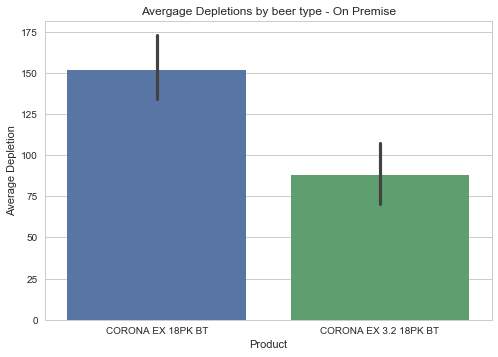

In [79]:
#plot average depletion per beer type for Off-premise
plt.title("Avergage Depletions by beer type - On Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset4)
graph.set(xlabel='Product', ylabel='Average Depletion');

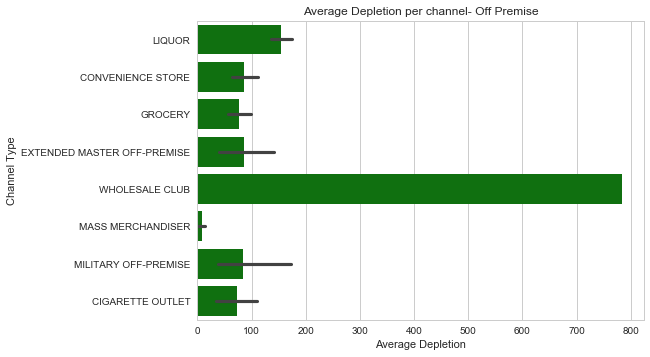

In [80]:
#plot average depletion per channel for Off-premise
plt.title("Average Depletion per channel- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset4, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

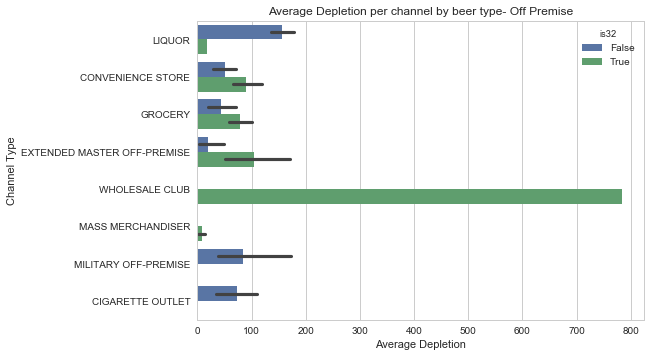

In [81]:
#plot Average Depletion per channel by beer type for Off-premise
plt.title("Average Depletion per channel by beer type- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset4)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [82]:
Regression_Off_pair4 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(RTL_CHANNEL_DSC)', data= subset4)
print(Regression_Off_pair4.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.038
Model:                                OLS   Adj. R-squared:                  0.028
Method:                     Least Squares   F-statistic:                     3.802
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           0.000216
Time:                            15:51:55   Log-Likelihood:                -1460.9
No. Observations:                     772   AIC:                             2940.
Df Residuals:                         763   BIC:                             2982.
Df Model:                               8                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

### Pair 5 

In [83]:
subset5 = Top5_Off_pairs_stores.loc[Top5_Off_pairs_stores['ITEM_MASTER_SKU_DSC'].isin(list(Top5_LowPoint_Off_Pairs_DF.loc[4, :]))].reset_index(drop=True)

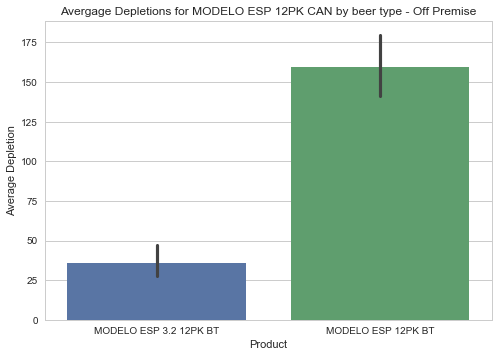

In [84]:
#plot average depletion per beer type for Off-premise
plt.title("Avergage Depletions for MODELO ESP 12PK CAN by beer type - Off Premise")
graph = sns.barplot(x = 'ITEM_MASTER_SKU_DSC', y="PROD_DEPLETION", data=subset5)
graph.set(xlabel='Product', ylabel='Average Depletion');

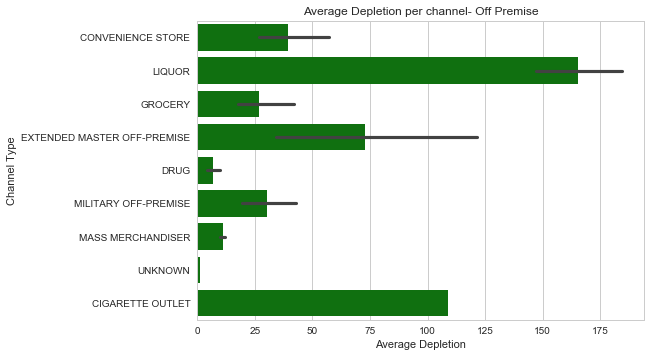

In [85]:
#plot average depletion per channel for Off-premise
plt.title("Average Depletion per channel- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', data=subset5, color = 'Green')
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

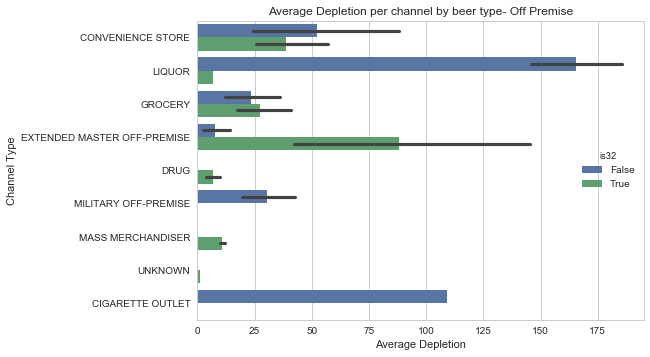

In [86]:
#plot Average Depletion per channel by beer type for Off-premise
plt.title("Average Depletion per channel by beer type- Off Premise")
graph = sns.barplot(x= 'PROD_DEPLETION', y='RTL_CHANNEL_DSC', hue="is32", data=subset5)
graph.set(xlabel='Average Depletion', ylabel='Channel Type');

In [87]:
Regression_Off_pair5 = smf.ols(formula='np.log(PROD_DEPLETION) ~ C(ITEM_MASTER_SKU_DSC)+ C(RTL_CHANNEL_DSC)', data= subset5)
print(Regression_Off_pair5.fit().summary())

                              OLS Regression Results                              
Dep. Variable:     np.log(PROD_DEPLETION)   R-squared:                       0.258
Model:                                OLS   Adj. R-squared:                  0.251
Method:                     Least Squares   F-statistic:                     40.00
Date:                    Thu, 06 Jul 2017   Prob (F-statistic):           1.95e-61
Time:                            15:51:56   Log-Likelihood:                -1879.4
No. Observations:                    1046   AIC:                             3779.
Df Residuals:                        1036   BIC:                             3828.
Df Model:                               9                                         
Covariance Type:                nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------